# Huffman Code

[Click here to run this chapter on Colab](https://colab.research.google.com/github/AllenDowney/DSIRP/blob/main/notebooks/huffman.ipynb)

A [Huffman code](https://en.wikipedia.org/wiki/Huffman_coding) is a "type of optimal prefix code that is commonly used for lossless data compression".
There are three parts of that definition we have to unpack: "code", "prefix", and "optimal".

In this context, a "code" is a mapping from symbols to bit strings.
For example, [ASCII](https://en.wikipedia.org/wiki/ASCII) is a character encoding that maps from characters (like letters, numbers, and punctuation) to seven-bit integers.
Since all ASCII bit strings are the same length, it is a "fixed-length code", as contrasted with Huffman codes, which are "variable-length codes".

In order to decode something encoded in a variable-length code, there has to be some way to figure out where one bit string ends and the next begins.
In general, there are three ways to solve this problem:

* One option is to begin each bit string with a special sequence that indicates its length. This is [how Unicode works](https://stackoverflow.com/questions/1543613/how-does-utf-8-variable-width-encoding-work).

* Another option is to end each bit string with a special sequence that marks the end.

* The third option is to use a "prefix code", which is how Huffman codes work.

A prefix code is a code where no whole bit string in the code is a prefix of any bit string in the code.
If a code has this property, we can decode it by reading bits one at a time and checking to see whether we have completed a valid bit string.
If so, we know we are at the end of the bit string, because it cannot be the prefix of another bit string.

For example, the following is a prefix code with only three symbols:

```
symbol        bit string
x             1
y             01
z             001
```

In this code, we can encode the string `xyz` with the bit string `101001`, and we can decode the result without ambiguity.

So that's what it means to say that a Huffman code is a prefix code; finally, Huffman codes are "optimal" in the sense that they give short codes to the most common symbols and longer codes to the least common symbols.
The result is that they minimize the average number of bits needed to encode a sequence of symbols.

However, in order to achieve this feat, we have to know the relative frequencies of the symbols.
One way to do that is to start with a "corpus", which is a text that contains the symbols in the proportions we expect for the text we will encode.

As an example, I'll use the text from the [Huffman code Wikipedia page](https://en.wikipedia.org/wiki/Huffman_coding).

In [29]:
text = """jim quickly realized that the beautiful gowns are expensive (such as a character in a file). Huffman's variable-length code
As in other However, The algorithm"""

We can use a `Counter` to count the number of times each symbol appears in this text.

In [64]:
from collections import Counter

c = Counter(text)
c

Counter({'j': 1,
         'i': 10,
         'm': 3,
         ' ': 23,
         'q': 1,
         'u': 5,
         'c': 5,
         'k': 1,
         'l': 7,
         'y': 1,
         'r': 8,
         'e': 17,
         'a': 13,
         'z': 1,
         'd': 2,
         't': 8,
         'h': 8,
         'b': 2,
         'f': 4,
         'g': 3,
         'o': 5,
         'w': 2,
         'n': 6,
         's': 6,
         'x': 1,
         'p': 1,
         'v': 3,
         '(': 1,
         ')': 1,
         '.': 1,
         'H': 2,
         "'": 1,
         '-': 1,
         '\n': 1,
         'A': 1,
         ',': 1,
         'T': 1})

Now let's see how we can use these counts to build a Huffman code.
The first step is to build a Huffman tree, which is a binary tree where every node contains a count and some nodes contain symbols.

To make a Huffman tree, we start with a sequence of nodes, one for each symbol.
To represent nodes, I'll use a `namedtuple`.

In [65]:
from collections import namedtuple


Node = namedtuple('Node', ['count', 'letter', 'left', 'right'])

For example, here's a node that represents the symbol `a` with count `4`.
Since this node has no children, it is a leaf node.

In [130]:
left = Node(4, 'a', None, None)
left

Node(count=4, letter='a', left=None, right=None)

And here's another leaf node that represents the symbol `n` and its count.

In [131]:
right = Node(2, 'n', None, None)
right

Node(count=2, letter='n', left=None, right=None)

One reason we're using a namedtuple is that it behaves like a tuple, so if we compare two `Node` objects, we get a tuple-like sorting order.

In [6]:
left > right

True

If two nodes have the same `count`, they get sorted in alphabetical order by `letter`.

## Making trees

Given these two leaf nodes, we can make a tree like this:

In [132]:
count = left.count + right.count
root = Node(count, '\0', left, right)
root

Node(count=6, letter='\x00', left=Node(count=4, letter='a', left=None, right=None), right=Node(count=2, letter='n', left=None, right=None))

Because `root` has children, it is not a leaf node; it is an interior node.
In a Huffman tree, the interior nodes do not represent symbols, so I have set `letter` to the null character `\0`.
The count of an interior node is the sum of the count of its children.

Now, to build a Huffman tree, we'll start with a collection of nodes, one for each symbol, and build the tree "bottom up" by following these steps:

1) Remove the node with the lowest count.

2) Remove the node with the next lowest count.

3) Make a new node with the nodes we just removed as children.

4) Put the new node back into the collection.

5) If there's only one node in the collection, it's the Huffman tree, and we're done.

In general, we could use any kind of collection, but if we look at the operations required by this algorithm, the most efficient option is a heap.

But we'll start by iterating through the `Counter` and making a list of `Node` objects, 

In [66]:
nodes = [Node(count, letter, None, None) 
         for (letter, count) in c.items()]
nodes

[Node(count=1, letter='j', left=None, right=None),
 Node(count=10, letter='i', left=None, right=None),
 Node(count=3, letter='m', left=None, right=None),
 Node(count=23, letter=' ', left=None, right=None),
 Node(count=1, letter='q', left=None, right=None),
 Node(count=5, letter='u', left=None, right=None),
 Node(count=5, letter='c', left=None, right=None),
 Node(count=1, letter='k', left=None, right=None),
 Node(count=7, letter='l', left=None, right=None),
 Node(count=1, letter='y', left=None, right=None),
 Node(count=8, letter='r', left=None, right=None),
 Node(count=17, letter='e', left=None, right=None),
 Node(count=13, letter='a', left=None, right=None),
 Node(count=1, letter='z', left=None, right=None),
 Node(count=2, letter='d', left=None, right=None),
 Node(count=8, letter='t', left=None, right=None),
 Node(count=8, letter='h', left=None, right=None),
 Node(count=2, letter='b', left=None, right=None),
 Node(count=4, letter='f', left=None, right=None),
 Node(count=3, letter='g', 

Next we'll use the heap module to convert the list to a heap.

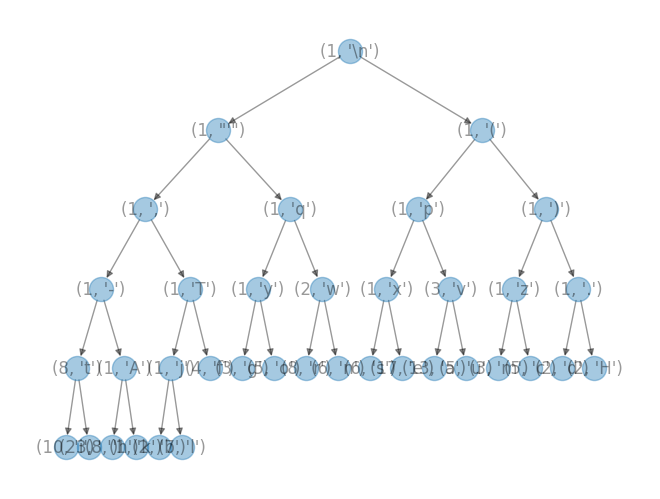

In [67]:
from heapq import heapify, heappop, heappush

data = [(item.count, item.letter) for item in nodes]


heap = nodes.copy()
heapify(heap)

dis_heap = data.copy()
heapify(dis_heap)
#heap

import networkx as nx

def make_dag(heap):
    """Make a NetworkX graph that represents the heap."""
    G = nx.DiGraph()
    
    for i in range(1, len(heap)):
        parent = (i-1)//2
        G.add_edge(parent, i)
    
    return G

G = make_dag(dis_heap)

from EoN import hierarchy_pos

def draw_heap(heap):
    G = make_dag(heap)
    pos = hierarchy_pos(G)
    labels = dict(enumerate(heap))
    nx.draw(G, pos, labels=labels, alpha=0.4)

draw_heap(dis_heap)

Now we can use the heap to make a tree.

**Exercise:** Write a function called `make_tree` that takes a heap of `Node` objects and uses the algorithm I described to make and return a Huffman tree. In other words, it should join up the nodes into a tree and return the root node.

In [68]:
def make_tree(node_heap):
    while len(node_heap) > 1:
        right = heappop(node_heap)
        left = heappop(node_heap)

        count = left.count + right.count

        root = Node(count, '\0', left, right)
        heappush(node_heap, root)
        
    return(node_heap[0])
                
        


make_tree(heap)


Node(count=158, letter='\x00', left=Node(count=93, letter='\x00', left=Node(count=50, letter='\x00', left=Node(count=27, letter='\x00', left=Node(count=14, letter='\x00', left=Node(count=7, letter='l', left=None, right=None), right=Node(count=7, letter='\x00', left=Node(count=4, letter='\x00', left=Node(count=2, letter='\x00', left=Node(count=1, letter=')', left=None, right=None), right=Node(count=1, letter='(', left=None, right=None)), right=Node(count=2, letter='\x00', left=Node(count=1, letter="'", left=None, right=None), right=Node(count=1, letter='\n', left=None, right=None))), right=Node(count=3, letter='v', left=None, right=None))), right=Node(count=13, letter='a', left=None, right=None)), right=Node(count=23, letter=' ', left=None, right=None)), right=Node(count=43, letter='\x00', left=Node(count=23, letter='\x00', left=Node(count=12, letter='\x00', left=Node(count=6, letter='s', left=None, right=None), right=Node(count=6, letter='n', left=None, right=None)), right=Node(count=1

Use this code to test it.

In [69]:
tree = make_tree(heap)

## Drawing the Tree

To see what it looks like, we'll use NetworkX and a library called EoN.

In [137]:
try:
    import EoN
except ImportError:
    !pip install EoN

The following function traverses the Huffman tree and makes a NetworkX `DiGraph`.

In [70]:
import networkx as nx

def add_edges(parent, G):
    """Make a NetworkX graph that represents the tree."""
    if parent is None:
        return
    
    for child in (parent.left, parent.right):
        if child:
            G.add_edge(parent, child)
            add_edges(child, G)

In [71]:
G = nx.DiGraph()
add_edges(tree, G)

The following function traverses the tree again and collects the node labels in a dictionary.

In [72]:
def get_labels(parent, labels):
    if parent is None:
        return
    
    if parent.letter == '\0':
        labels[parent] = parent.count
    else:
        labels[parent] = parent.letter
        
    get_labels(parent.left, labels)
    get_labels(parent.right, labels)

In [73]:
labels = {}
get_labels(tree, labels)

In [74]:
def get_edge_labels(parent, edge_labels):
    if parent is None:
        return
    
    if parent.left:
        edge_labels[parent, parent.left] = '0'
        get_edge_labels(parent.left, edge_labels)
        
    if parent.right:
        edge_labels[parent, parent.right] = '1'
        get_edge_labels(parent.right, edge_labels)

In [75]:
edge_labels = {}
get_edge_labels(tree, edge_labels)
len(edge_labels)

72

Now we're ready to draw.

In [76]:
from EoN import hierarchy_pos

def draw_tree(tree):
    G = nx.DiGraph()
    add_edges(tree, G)
    pos = hierarchy_pos(G)
    labels = {}
    get_labels(tree, labels)
    edge_labels = {}
    get_edge_labels(tree, edge_labels)
    nx.draw(G, pos, labels=labels, alpha=0.4)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='C1')

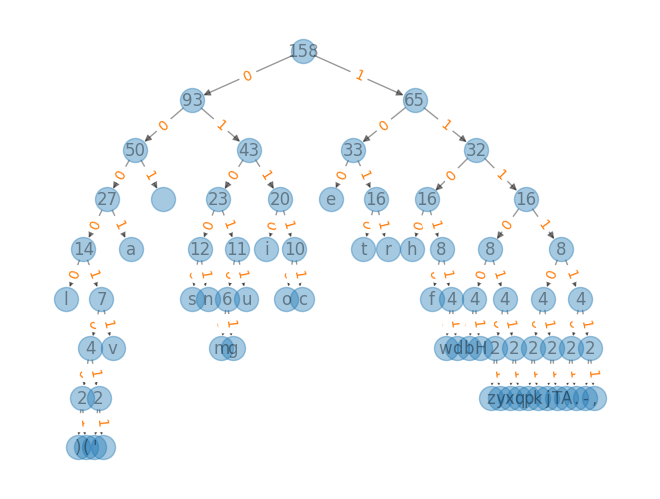

In [77]:
draw_tree(tree)

The result might not be identical to the tree on [the Wikipedia page](https://en.wikipedia.org/wiki/Huffman_coding), but a letter in our tree should be on the same level as the same letter in their tree.

## Making the Table

The following function traverses the tree, keeping track of the path as it goes. When it finds a leaf node, it makes an entry in the table.

In [78]:
def is_leaf(node):
    return node.left is None and node.right is None

In [79]:
def make_table(node, path, table):
    if node is None:
        return
    
    if is_leaf(node):
        table[node.letter] = path
        return
    
    make_table(node.left, path+'0', table)
    make_table(node.right, path+'1', table)

In [80]:
table = {}
make_table(tree, '', table)

table

{'l': '00000',
 ')': '00001000',
 '(': '00001001',
 "'": '00001010',
 '\n': '00001011',
 'v': '000011',
 'a': '0001',
 ' ': '001',
 's': '01000',
 'n': '01001',
 'm': '010100',
 'g': '010101',
 'u': '01011',
 'i': '0110',
 'o': '01110',
 'c': '01111',
 'e': '100',
 't': '1010',
 'r': '1011',
 'h': '1100',
 'f': '11010',
 'w': '110110',
 'd': '110111',
 'b': '111000',
 'H': '111001',
 'z': '1110100',
 'y': '1110101',
 'x': '1110110',
 'q': '1110111',
 'p': '1111000',
 'k': '1111001',
 'j': '1111010',
 'T': '1111011',
 'A': '1111100',
 '.': '1111101',
 '-': '1111110',
 ',': '1111111'}

## Encoding

We can use the table to encode a string by looking up each symbol in the string and joining the results into a bit string.

In [81]:
def encode(s, table):
    t = [table[letter] for letter in s]
    return ''.join(t)

Here's an example, noting that we can encode strings other than the corpus we started with, provided that it contains no symbols that were not in the corpus.

In [89]:
m = """The output from Huffman's algorithm can be viewed as a variable-length code table for encoding a source symbol 
(such as a character in a file). The algorithm derives this table from the estimated probability or frequency of occurrence (weight) 
for each possible value of the source symbol. As in other entropy encoding methods, more common symbols are generally represented using 
fewer bits than less common symbols. Huffman's method can be efficiently implemented, finding a code in time linear to the number of input 
weights if these weights are sorted. However, although optimal among methods encoding symbols separately, Huffman coding is not always 
optimal among all compression methods - it is replaced with arithmetic coding or asymmetric numeral systems if a better compression ratio 
is required."""

code = encode(m, table)



print("length of utf-8 " + str(len(m) * 8))
print("length of huffman " + str(len(code)))
print(code)

length of utf-8 6480
length of huffman 3660
11110111100100001011100101110101111000010111010001110101011011100101000011110010101111010110100101000001010010000101001000001000100000010101011101011011010101100010100001011110001010010011110001000010000110110100110110100110111001000101000001000100100001100011011011000011110000000010011111100000010001001010101101011000010111101110110111100001101000011110000000010000111010011101011001100010010111101110110111011001001010101001000100101000011100101110110111110000101000111010101010011100001110000000010000101100001001010000101101111110000100010100000100010010111111000001101100010111110101001011001011001001001000100111010011000000100000010001111101001111101111001000010001000000101010111010110110101011000101000011101111001011011000001110001000001101011000110010000011010000111100000000100001110101011011100101000011010110010000110001000101001100101000001101010011011100111110001011011101110000001111000011000000011010101110101001011101011001110101011100

## Decoding

To decode the bit string, we start at the top of the tree and follow the path, turning left when we see a `0` and right when we see a `1`.
If we get to a leaf node, we have decoded a symbol, so we should record it and then jump back to the top of the tree to start decoding the next symbol.

**Exercise:** Write a function called `decode` that takes as parameters a string on 0s and 1s and a Huffman tree. It should decode the message and return it as a string.

In [59]:
def decode(code, tree, prn = False):
    root = tree
    decode_list = []
    for num in code:
        if num == "0":
            root = root.left
        else:
            root = root.right

        if root.letter != "\0":
            decode_list.append(root.letter)
            root = tree
    
    if prn:
        print(''.join(decode_list))
    else:
        return ''.join(decode_list)
    



In [90]:
decode(code, tree, True)

The output from Huffman's algorithm can be viewed as a variable-length code table for encoding a source symbol 
(such as a character in a file). The algorithm derives this table from the estimated probability or frequency of occurrence (weight) 
for each possible value of the source symbol. As in other entropy encoding methods, more common symbols are generally represented using 
fewer bits than less common symbols. Huffman's method can be efficiently implemented, finding a code in time linear to the number of input 
weights if these weights are sorted. However, although optimal among methods encoding symbols separately, Huffman coding is not always 
optimal among all compression methods - it is replaced with arithmetic coding or asymmetric numeral systems if a better compression ratio 
is required.


*Data Structures and Information Retrieval in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)